In [26]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [55]:
k = 5 # number of pioneer nodes
r = 5 # radius
theta = np.random.uniform(0,1)
pioneer_nodes = np.array([[r*np.cos(2*np.pi*(theta + i/k)), r*np.sin(2*np.pi*(theta + i/k))] for i in range(k)])

In [58]:
pioneer_nodes

array([[-1.07399894, -4.88329052],
       [ 4.31240134, -2.53045345],
       [ 3.73920954,  3.31938428],
       [-2.00144275,  4.58194575],
       [-4.97616919, -0.48758607]])

In [60]:
G = nx.Graph()
for i in range(k):
    G.add_nodes_from([
                        (i, {'xy': [pioneer_nodes[i,0], pioneer_nodes[i,1]]}),
                      ])
    # G.nodes[0]


In [71]:
def TimeWindowFunction(t, i, k, alpha):
    mu = i / (k+1)
    lamda = -np.log(2)/np.log(mu)
    return 1/16 * (t**(2*lamda) * (t**lamda-1)**2)**(1/alpha)

T = np.arange(0, 1, 0.01)
sum = 0
for t in T:
    sum += TimeWindowFunction(t,5,5,0.2 )*0.01
print(sum)

7.282993489042751e-09


In [49]:
for i in range(k,100):
    print(i)

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [1]:
from train import *
import matplotlib.pyplot as plt
from utils import *

In [5]:
config = {
    'alpha':0.5,
    'decay':0.5,
    'thr': 1.2,
    'R': 0.05,
    'p': 0.25,
    'gamma': 1.0,
}
model = config_model(config)
# print(1000**2-(model.A==0).sum())
# print(spectral_radius(model.A))
rollout(config)

0.15333333333333332 0.115


{'objs': (-0.115,)}

In [6]:
model.N_hid

1000

In [4]:
# np.max(model.A)
rollout(config)

0.15 0.125


{'objs': (-0.125,)}

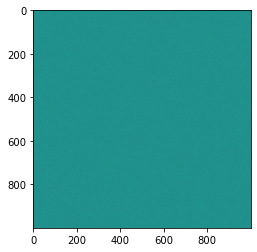

In [6]:
plt.imshow(model.A)
plt.show()


In [ ]:
train_loader, test_loader = MNIST_generation(train_num=100,
                                             test_num=250,
                                             batch_size=13)

inference(model, train_loader, frames=20)

t = time.time()
rollout(config)
print(time.time()-t)

1.0000000000000016


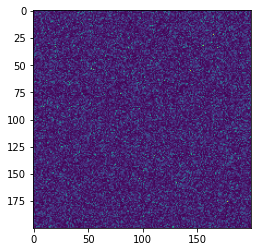

In [34]:
gamma_list = [np.random.gamma(1.0) for _ in range(40000)]
gamma_m = np.array(gamma_list).reshape(200,200)
gamma_m /= spectral_radius(gamma_m)
print(spectral_radius(gamma_m))
plt.imshow(gamma_m)
# plt.hist(gamma_list,bins=100)